# Sound Like Me: Audio Feature Based Song Recommendation

### Recommend songs that sound similar using a self-labeling approach. 

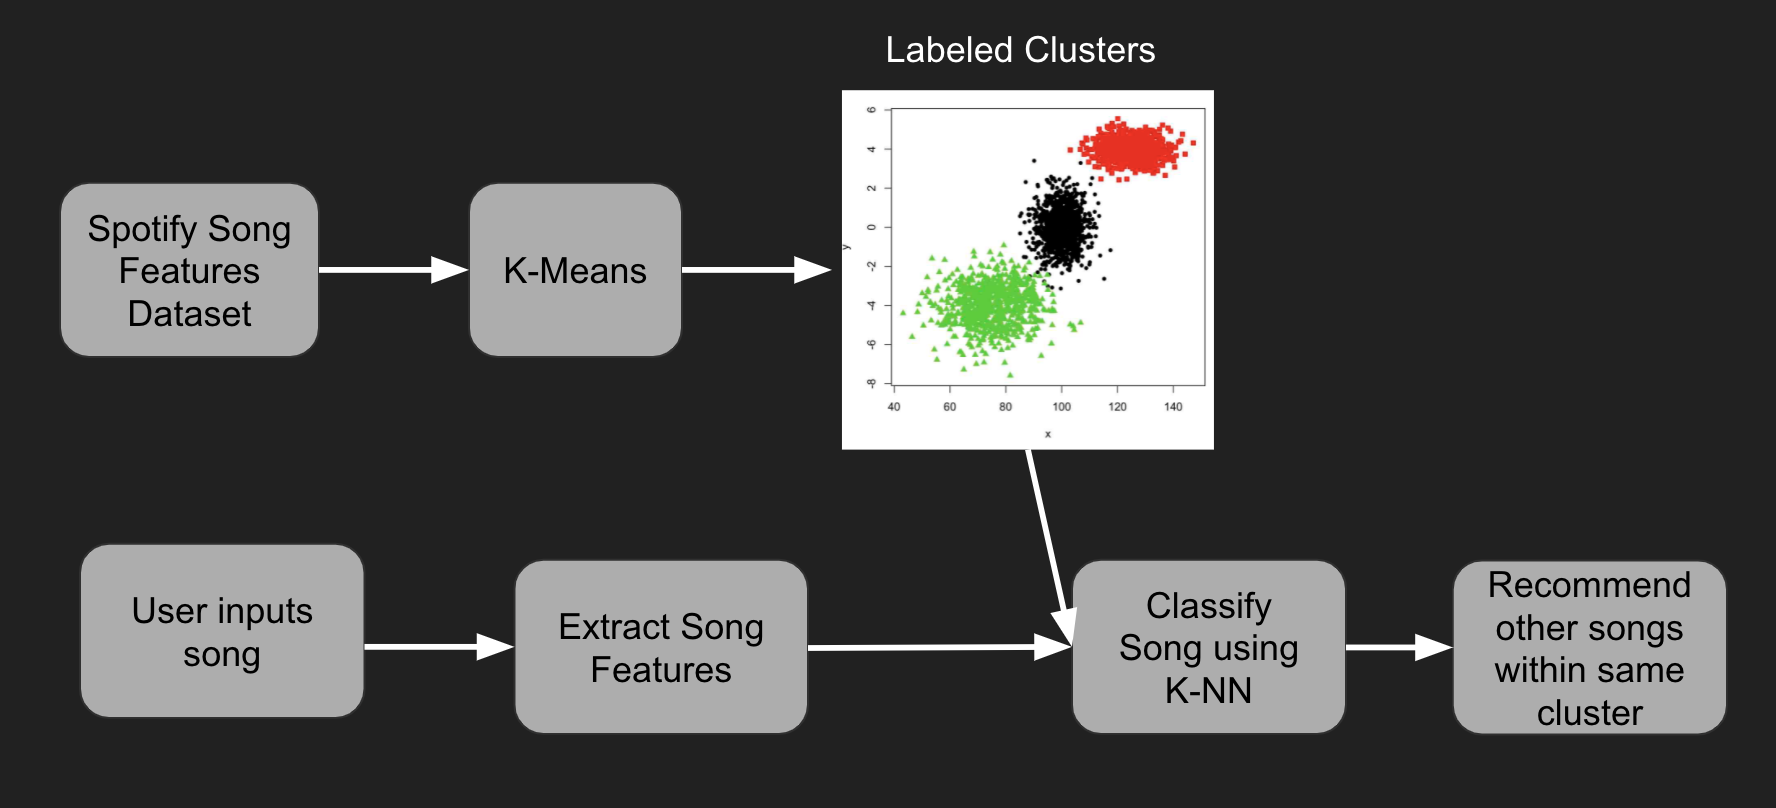





# Introduction/Background
Music has always been a staple of our lives. It conveys emotions and brings back memories for us all. Having such a prominent effect on our lives, we clearly see why massive companies like Spotify, Youtube, and Soundcloud all compete to implement innovative technologies to provide the best music streaming service for the consumer. A key feature used by all of these companies is a song recommendation system. With such services, streaming platforms can continue providing enjoyable content to a user, tailored to their likings, without additional user input. We want to explore this feature further to help us connect powerful machine learning algorithms with what we love and enjoy on a daily basis - music.

# Problem definition
While we do not know the underlying algorithms for the Spotify recommendation system, it seems to suggest songs based on other users listening history rather than inference. Spotify is unable to recommend new songs that "sound similar” to the current song being listened to. Our goal is to provide music recommendations based on how closely the quantifiable features of a song match to others, with the assumption that these features contain the information that makes two songs sound similar to the human ear.  

# Data Collection
By reaching out to fellow georgia tech students, we were able to acquire around 6 playlists, totaling to over 250 songs. We utilized spotify’s API in order to extract the unique songs out of these playlists, and then perform feature extraction on these songs. We are able to construct an 11-dimensional feature vector out of the data returned from the api, consisting of the following numeric features: 

danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness	liveness, valence, tempo

# Methods
We take the 11-dimensional feature vectors that compose the dataset, and extract two of the principal components after applying PCA. This projects the data points onto two of the axes that have the largest amount of variance. We then send this reduced data into the K-means algorithm in order to return clusters. We run K means several times with different cluster sizes to try and find the optimal cluster size using the elbow method.  

# Results and Discussion
Initially our goal was to implement a recommendation system based on K-means clustering. However, after analyzing our results we think that a density based clustering algorithm such as DBSCAN will better suit our needs. Upon taking a look at our k-means clustering, we see that inter cluster difference seems to be low and see the outliers were grouped into a cluster of there own which yields high intra cluster data, none of which are ideal. Furthermore, we see that our data contains some high density regions which is something k-means is not able to distinguish. DBSCAN would be able to group high density regions together while omitting the far data points from being recommended. And lastly, we see that our silhouette scores do not change as the number of clusters we use changes implying that there is no number of clusters that could potentially serve to maximize the score.





# Install libraries
- SpotiPy is a python friendly wrapper around spotify's public API 
- Pandas is a library that makes working with big datasets easy

# Dataset 
Spotify playlists containing 2553 songs

In [269]:
playlists = """
https://open.spotify.com/playlist/0Bie8YaaPo7t7pwwihn2EB?si=31f790531b85444c
https://open.spotify.com/playlist/3kHSFQiGtPML3w4AE5OJYv?si=gsOxTQIGQL-zimB4FNbk6A
https://open.spotify.com/playlist/1zXwPKbXqLEbb5kBo2oiK5?si=Fswjd5A-TAyptYq9frJcXg
https://open.spotify.com/playlist/0inOzNw7liwlduc94yqTV0?si=H70V7XtyTru8yUygxM2PVQ
https://open.spotify.com/playlist/37i9dQZF1DX0XUsuxWHRQd?si=ed6d9c1a8dd845d7
https://open.spotify.com/playlist/37i9dQZF1DZ06evO3qQrNm?si=7422e4a1c39e477b
https://open.spotify.com/playlist/2a6OSlFchVcDonrXMMJ6EM?si=a3f65432aa0b4a96
https://open.spotify.com/playlist/1G86O8drytJbZ5m2I0EDpX?si=786173b28f5e420b
https://open.spotify.com/playlist/4gMQy0k4DNFQQQhxpUwzOS?si=f6d2347c9c63423c
https://open.spotify.com/playlist/2lnuEEWTiL6vIVEV0isaht?si=fa69188e3c4b4e8a
https://open.spotify.com/playlist/3T9rfZV18sLKoR1AwydfCs?si=f6896820eecc4461
https://open.spotify.com/playlist/2QS8VJlllWj5hVG9JsOvDY?si=36adcad78b61423d
https://open.spotify.com/playlist/78svu4zIRmrKYeTYA4l0BX?si=9ed11bd7a1db4d0a
https://open.spotify.com/playlist/0Bz7z7CgnsqoEfWk4u35vW?si=5fcce7a1ed0e401a
https://open.spotify.com/playlist/4T7q2RiysfoRkMA9SqJE7m?si=f30b4d010703461e
https://open.spotify.com/playlist/37i9dQZF1DZ06evO3Jefw4?si=2a88b7a1e5aa4991
https://open.spotify.com/playlist/37i9dQZF1DXcRXFNfZr7Tp?si=2e1db894a6164161
https://open.spotify.com/playlist/37i9dQZF1EVHGWrwldPRtj?si=5c4f6a8449ad4906
""".strip()

# Pipeline Logic 

End to end machine learning pipeline for song recommendations: 
Input = N spotify playlists
Pipeline: 
1. Pull each song feature from playlist in spotify API -> Dataset
2. Fit clustering model (KMeans or DBScan) to find song groups -> "Pseudo Labeled" Dataset
3. Fit classifier model (KNN) to now labeled dataset 
4. Now take in a new song, and use the classifier to predict its class. 
5. All songs in that class are potential "similar" songs to the input song. 
6. ??? 
7. Profit  

## Stage 1.1: 

- Spotify API to pull song data from playlists 
- Spotify API to pull feature data for each song 

output: 

np.array with shape (NumSongs, FeatureSize)

In [270]:
import itertools
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

api = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials('f2883f3df24c43bc9126b3248f2c7ff2', '7b66ce34cd7346afaef61c3f4a12c226'), )

# playlist urls -> playlist_ids
playlist_ids = [token.split('?si=')[0] for token in [p.split('/playlist/')[1] for p in playlists.split('\n')]]
# print(playlist_ids)

# playlist_tracks -> track_ids 
playlist_tracks = list(itertools.chain(*[api.playlist_tracks(pid)['items'] for pid in playlist_ids]))
tids = set()

# track_ids -> features 
track_ids = set([track['track']['uri'] for track in playlist_tracks])
print(f'Extracted {len(track_ids)} unique track ids')
track_ids = list(track_ids)


def get_api_features(track_ids):
    """
     Spotify API only allows us to retrieve features for songs in batches of 100. 
     To bypass this we break up the tracks into multiple batches of requests and merge them together. 
    """

    # polymorphic function gang ;) 
    if not isinstance(track_ids, list): 
      return api.audio_features(track_ids)

    features = []
    batchLimit = 100 
    current = 0 
    while current < len(track_ids):
      featureBatch = api.audio_features(track_ids[current:current+batchLimit]) 
      features.extend(featureBatch)
      current += batchLimit

    return features

api_features = get_api_features(track_ids)


Extracted 1312 unique track ids


In [271]:
all_data = pd.DataFrame().from_dict(api_features)

# 11 dim feature vector
desired_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

data_frame = all_data[desired_features]


# normalize!
data_frame=(data_frame-data_frame.mean())/data_frame.std()
data_frame

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,-0.171983,-0.458198,-0.075457,-0.229922,0.830780,-0.558356,1.408334,-0.313806,-0.753741,0.265188,-1.097570
1,-0.523519,0.351802,1.588406,0.693358,-1.202771,-0.509578,-0.938446,-0.323858,-0.565960,-0.382259,-1.024272
2,-1.263210,0.530560,-1.462010,0.273435,0.830780,-0.577037,-0.776634,-0.323831,1.019116,-0.245954,1.726882
3,-0.259867,-1.312887,0.756474,-0.825299,0.830780,2.582127,1.528939,-0.309415,-0.387460,-0.318366,-0.280451
4,-1.673335,1.552835,1.588406,0.956024,-1.202771,-0.212757,-0.898044,-0.309415,0.026658,-1.549368,1.093909
...,...,...,...,...,...,...,...,...,...,...,...
1307,1.973851,-0.474956,0.756474,-0.324345,0.830780,-0.300973,0.877670,-0.322212,-0.416020,0.103327,0.670562
1308,-0.648022,-2.178748,-1.462010,-1.860512,0.830780,-0.726485,2.702832,0.733398,-0.676630,-1.336392,-1.596686
1309,0.443205,0.949525,-1.184700,1.056627,0.830780,0.143219,-0.641958,-0.323858,-0.009041,1.274695,-0.809281
1310,-1.519538,1.860076,1.588406,1.361182,-1.202771,3.609581,-0.648390,-0.323858,-0.437440,-0.254473,-1.022048


## Stage 1.2: Apply PCA
Seeing if PCA is worth using. In this case it might not be, since we don't have exorbitantly many features, but it produces a cool visualization  

[[ 1.23608774 -0.69856766]
 [-0.79376304  0.37872831]
 [-0.92508039  1.94414271]]


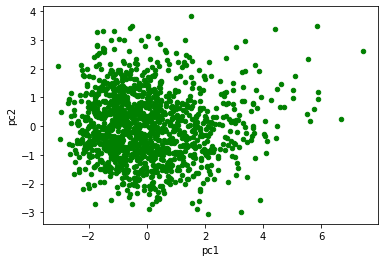

In [272]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_frame)
pdf = pd.DataFrame(data=principalComponents, columns=['pc1', 'pc2'])
pdf.plot.scatter(x='pc1',y='pc2', c='Green')
dataset = pdf.to_numpy() #pdf.to_numpy()

print(dataset[:3])

## Stage 2: Build Music Clusters 
Dataset -> K-means -> Classes 


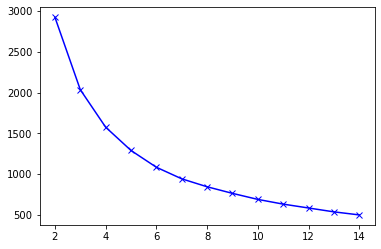

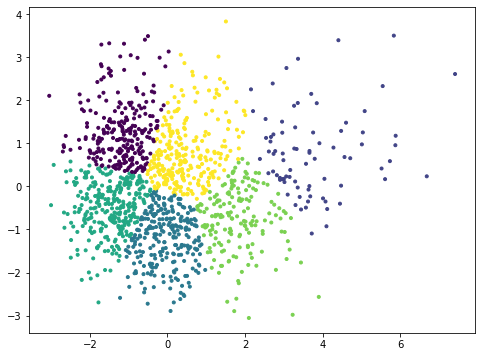

In [273]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt 

distortions = [] #loss values to use for elbow method
scores = [] #silhoutte scores for different number of clusters

I = range(2, 15) #iteration of kmeans to 15 clusters for evaluation
for i in I:
  kmeans = KMeans(n_clusters=i, random_state=0).fit(dataset)
  distortions.append(kmeans.inertia_)
  scores.append(silhouette_score(dataset, kmeans.labels_))

plt.plot(I, distortions, 'bx-')

kmeans.labels_

kmeans.cluster_centers_

kmeans = KMeans(n_clusters=6, random_state=0).fit(dataset)

plt.figure(figsize=(8, 6))
plt.scatter(dataset[:,0], dataset[:,1], c=kmeans.labels_, marker='.')

score = silhouette_score(dataset, kmeans.labels_)

### The Elbow Method, and on K-Means vs DBScan
In the above elbow chart, we have plotted the K means loss as a function of the number of clusters used. Using the elbow method, we conclude that the optimal number of clusters using K means is 5. We see the results of using 5 clusters in the above plot. Different colors correspond to different clusters. We can immediately see many issues with these results. Visually, we do not see a clear division between clusters in the high density regions. The intercluster distance between points seems to be very low, whereas the intracluster distance seems to be very large. For instance, some yellow data points are directly adjacent to blue data points. But, within individual clusters, there is a very large spread. This behaviour is undesireable and shows that K means is not a particularly effect algorithm for these data.

Another key issue is the lack of density dependence of K means. We can see a high density and a low density region within these data. We believe our performnce could improve if these densities are considered. Of the unsupervised machine learning techniques taught in our class, the only method which differentiates based on density is DBSCAN. We attempt to use that method below.

While DBSCAN takes into account the density of data, it can not simultaneously classify high and low density data. For this reason we must either classify the low density data as outliers, or overlook variations in the high density region of our data. We chose the former of these options. For visualization purposes, we have also plotted our data excluding the outlier datapoints. The result is seen in the final figure. We can see that our original goal of using DBSCAN is accomplished in these results, the intracluster distance is low relative to the intercluster distance. 

## Now let's try DBScan

Num Clusters:  17


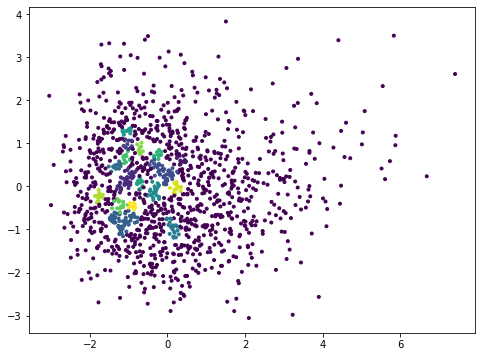

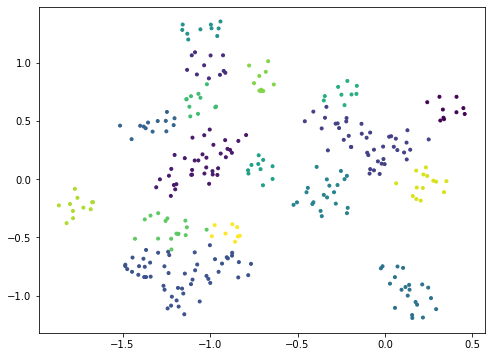

In [274]:
from sklearn.cluster import DBSCAN

db_clustering = DBSCAN(eps=0.14, min_samples=10).fit(dataset)
# print(db_clustering.labels_)
plt.figure(figsize=(8, 6))
plt.scatter(dataset[:,0], dataset[:,1], c=db_clustering.labels_, marker='.')

plt.figure(figsize=(8, 6))
mask = np.invert(np.in1d(db_clustering.labels_, -1))
plt.scatter(dataset[mask,0], dataset[mask,1], c=db_clustering.labels_[mask], marker='.')

print("Num Clusters: ", max(db_clustering.labels_)+1)

The above results are satisfactory. However, we lose the majority of our datapoints by classifying them as outliers. Therefore, our predictor can match songs to a few other very similar songs, but it fails to capture overall genres

Num Clusters:  17


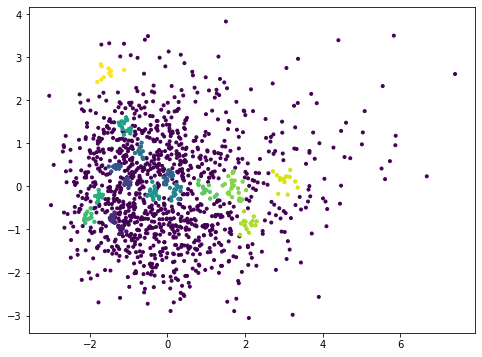

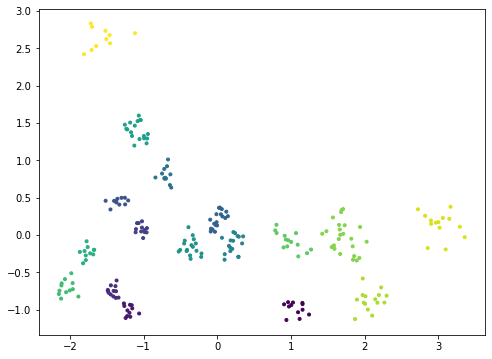

In [275]:
from sklearn.cluster import OPTICS
optics_clustering = OPTICS(min_samples=10).fit(dataset)
plt.figure(figsize=(8, 6))
plt.scatter(dataset[:,0], dataset[:,1], c=optics_clustering.labels_, marker='.')
mask = np.invert(np.in1d(optics_clustering.labels_, -1))
plt.scatter(dataset[mask,0], dataset[mask,1], c= optics_clustering.labels_[mask], marker='.')
plt.figure(figsize=(8, 6))
mask = np.invert(np.in1d(optics_clustering.labels_, -1))
plt.scatter(dataset[mask,0], dataset[mask,1], c=optics_clustering.labels_[mask], marker='.')

print("Num Clusters: ", max(optics_clustering.labels_)+1)

## Stage 3: Application Endpoint
Now that we've done all this complicated stuff, let's make it useful. We can now take in a song, and use our model to recommend another song.

### 3.1 Fit KNN Classifer on dataset

In [276]:
X = dataset
y = db_clustering.labels_ # [0, 0, 1, 1]
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

###3.2 Apply Classifer to dataset 

In [277]:
def api_to_numpy(api_feature): 
  data_frame = pd.DataFrame().from_dict(api_feature)[desired_features].to_numpy()
  data_frame=(data_frame-data_frame.mean())/data_frame.std()
  return data_frame

def apply_pca(pca, fvec): 
  return pca.fit_transform(data_frame)

def get_cluster(clf, fv): 
  return clf.predict(fv)


index = 0
track_id = all_data.loc[index]['id']
# track_name = all_data.loc[index]['name']
print('track_id:', track_id, 'track_name:', f'')
features = get_api_features(track_id)
pca_fv = np.array([dataset[index]])
print('model input: ', pca_fv)
cluster = get_cluster(knn_classifier, pca_fv)
print('belongs to cluster:', cluster)

track_id: 7dJN4NWQuqCjWwIT3UwOps track_name: 
model input:  [[ 1.23608774 -0.69856766]]
belongs to cluster: [-1]


### 3.3 Now we have the "Similar Song" cluster! 
Let's use this to recommend songs now 
1. find all the song indices in the same cluster


In [278]:
similar_song_indices = np.argwhere(db_clustering.labels_ == cluster)